In [1]:
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing import image
from mlxtend.plotting import plot_confusion_matrix
from skimage import io
from joblib import dump, load
import math

# Utilitário

In [2]:
# caminho para o dataset de imagens
path = 'z:/HAM10000/' 

labels = [
    'akiec',
    'bcc',
    'bkl',
    'df',
    'mel',
    'nv',
    'vasc'
    ]

In [3]:
class_weight = {
    0:10015 / (327*7) , #akiec
    1:10015 / (514*7) , #bcc
    2:10015 / (1099*7) , #bkl
    3:10015 / (115*7) , #df
    4:10015/ (1113*7) , #mel
    5:10015 / (6705*7) , #nv
    6:10015 / (142*7) #vasc
}

In [4]:
import json
from scikitplot.metrics import plot_roc

def clf_metrics(y_true, y_pred,class_names, title):
    print("Matriz de Confusão:")
    fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_true, y_pred),
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                                figsize = (7,5) )
    
    plt.savefig('results/'+title+'.png')
    plt.show()
    print("")
    
    clf_report = classification_report(y_true,y_pred, target_names = class_names)
    print(clf_report)
    clf_report = classification_report(y_true,y_pred, target_names = class_names, output_dict = True)
    filename = 'results/'+ title + '.json'
    with open(filename, 'w') as json_file:
        json.dump(clf_report, json_file)
        
def clf_roc_curve(y_true, y_probas, title):
    print("Roc Curve:")
    ax = plot_roc(y_true, y_probas, title = title, figsize=(10,10) )
    
    plt.savefig('results/'+title +'-ROCcurve.png')
    plt.show()
    print("")
    
    
    

In [5]:
def decode_binary(target):
    for i in range(0, len(target)):
        if(target[i] == 1):
            return i

In [6]:
def normalizar(x):
    x_mean = np.mean(x)
    x_std = np.std(x)
    x = (x - x_mean)/x_std
    return x

In [7]:
targets = to_categorical([0,1,2,3,4,5,6], 7)

# Separação de Treinamento e Teste

In [70]:
filename = glob.glob(path + labels[0] + '/*.*', recursive = True)
l = len(filename)
target = l*[targets[0]]
prediction = target
for i in range(1,7):
    filename = glob.glob(path + labels[i] + '/*.*', recursive = True)
    l = len(filename)
    target = l*[targets[i]]
    prediction = np.concatenate((prediction,target))

In [71]:
imgpaths = glob.glob(path +'*/*.*', recursive = True)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(imgpaths, prediction, test_size=0.1, random_state=42)

In [11]:
np.save('dataset/X_train.npy', X_train)
np.save('dataset/X_test.npy', X_test)
np.save('dataset/y_train.npy', y_train)
np.save('dataset/y_test.npy', y_test)

# Load Dataset

In [8]:
X_train = np.load('dataset/X_train.npy')
X_test = np.load('dataset/X_test.npy')
y_train = np.load('dataset/y_train.npy')
y_test = np.load('dataset/y_test.npy')

In [15]:
import shutil
import os

def copy_img(img_path, label):
    i = decode_binary(label)
    head, tail = os.path.split(img_path)
    global labels
    label = labels[i]
    destino = 'imagens_de_teste/'+label+'_'+tail
    shutil.copy(img_path, destino)

for (img_path, label) in zip(X_test,y_test):
    copy_img(img_path, label)

# Extração de características com Xception

In [13]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input


xception_model = Xception(weights='imagenet', include_top=False, pooling='avg')

In [ ]:
xception_model.save('models/cnn_xception.h5')

In [14]:
def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    return x

def extract_features(path):
    tensor = path_to_tensor(path)
    return xception_model.predict(tensor).flatten()

In [15]:
train_features = np.array(list(map(extract_features, X_train)))
np.save('dataset/xception/train/features.npy', train_features)
print('..')

test_features = np.array(list(map(extract_features, X_test)))
np.save('dataset/xception/test/features.npy', test_features)
print('fim')

..
fim


# Extração de Features com VGG16

In [16]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

vgg16_model = VGG16(weights='imagenet', include_top=False, pooling='avg')

In [ ]:
vgg16_model.save('models/cnn_vgg16.h5')

In [17]:
def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def extract_features(path):
    tensor = path_to_tensor(path)
    return vgg16_model.predict(tensor).flatten()

In [18]:
train_features = np.array(list(map(extract_features, X_train)))
np.save('dataset/vgg16/train/features.npy', train_features)
print('..')

test_features = np.array(list(map(extract_features, X_test)))
np.save('dataset/vgg16/test/features.npy', test_features)
print('fim')

..
fim


# Extração de Features com ResNet50

In [19]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input

resnet50_model = ResNet50(include_top=False, weights='imagenet', pooling='avg')


In [ ]:
resnet50_model.save('models/cnn_resnet50.h5')

In [20]:
def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def extract_features(path):
    tensor = path_to_tensor(path)
    return resnet50_model.predict(tensor).flatten()

In [21]:
train_features = np.array(list(map(extract_features, X_train)))
np.save('dataset/resnet50/train/features.npy', train_features)
print('..')

test_features = np.array(list(map(extract_features, X_test)))
np.save('dataset/resnet50/test/features.npy', test_features)
print('fim')

..
fim


# Extração de Features com InceptionV3

In [22]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

inceptionv3_model = InceptionV3(include_top=False, weights='imagenet', pooling='avg')

In [23]:
resnet50_model.save('models/cnn_inceptionv3.h5')

In [24]:
def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def extract_features(path):
    tensor = path_to_tensor(path)
    return inceptionv3_model.predict(tensor).flatten()

In [25]:
train_features = np.array(list(map(extract_features, X_train)))
np.save('dataset/inceptionv3/train/features.npy', train_features)
print('..')

test_features = np.array(list(map(extract_features, X_test)))
np.save('dataset/inceptionv3/test/features.npy', test_features)
print('fim')

..
fim


# Load Features Dataset

In [9]:
train_features_xception = np.load('dataset/xception/train/features.npy')
test_features_xception = np.load('dataset/xception/test/features.npy')

In [10]:
train_features_vgg16 = np.load('dataset/vgg16/train/features.npy')
test_features_vgg16 = np.load('dataset/vgg16/test/features.npy')

In [11]:
train_features_resnet50 = np.load('dataset/resnet50/train/features.npy')
test_features_resnet50 = np.load('dataset/resnet50/test/features.npy')

In [12]:
train_features_inceptionv3 = np.load('dataset/inceptionv3/train/features.npy')
test_features_inceptionv3 = np.load('dataset/inceptionv3/test/features.npy')

# Classificador SVM - Xception vs Vgg16 vs ResNet50 vs InceptionV3

In [10]:
from sklearn.svm import SVC

In [11]:
def train_svm_classifier(x, y, kernel = 'rbf', normal = False, decode = True, C = 100, probability=True,  gamma = 0.001):
    if normal:
        x_train = np.array(list(map(normalizar,x)))
    else:
        x_train = x
        
    if decode:
        y_train = np.array(list(map(decode_binary,y)))
    else:
        y_train = y
    
    if(kernel == 'rbf'):
        clf = SVC(C = C, kernel = kernel, gamma = gamma, decision_function_shape = 'ovr', class_weight = 'balanced', probability=probability)
    else:
        clf = SVC(C = C, kernel = kernel, decision_function_shape = 'ovr', class_weight = 'balanced', probability=probability)
    
    clf.fit(x_train,y_train)
    
    return clf

In [15]:
y_t = np.array(list(map(decode_binary,y_test)))

In [13]:
class_names = labels

## SVM + Xception 

### Kernel Rbf

In [17]:
xception_svm = train_svm_classifier(train_features_xception, y_train)

In [18]:
predictions_xception = xception_svm.predict(test_features_xception)

Matriz de Confusão:


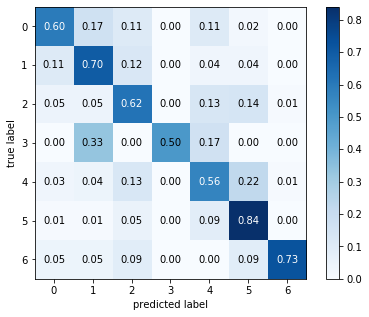


              precision    recall  f1-score   support

       akiec       0.57      0.60      0.58        47
         bcc       0.59      0.70      0.64        56
         bkl       0.51      0.62      0.56       106
          df       0.75      0.50      0.60         6
         mel       0.46      0.56      0.50       117
          nv       0.92      0.84      0.88       648
        vasc       0.84      0.73      0.78        22

    accuracy                           0.76      1002
   macro avg       0.66      0.65      0.65      1002
weighted avg       0.79      0.76      0.77      1002



In [19]:
clf_metrics(y_t, predictions_xception, class_names, title = 'Xception+SVM(kernel Rbf)')

In [41]:
dump(xception_svm, 'models/xception_svm_rbf.joblib') 

['models/xception_svm_rbf.joblib']

### Kernel RBF com normalização

In [33]:
xception_svm_norm = train_svm_classifier(train_features_xception, y_train, normal = True)

In [34]:
predictions_xception_norm = xception_svm_norm.predict(np.array(list(map(normalizar,test_features_xception))))

Matriz de Confusão:


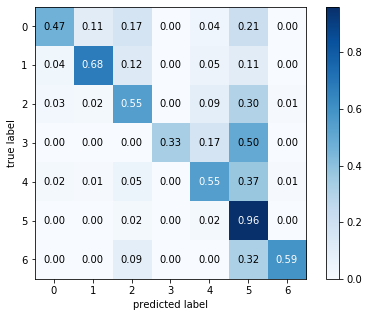


              precision    recall  f1-score   support

       akiec       0.76      0.47      0.58        47
         bcc       0.81      0.68      0.74        56
         bkl       0.63      0.55      0.59       106
          df       1.00      0.33      0.50         6
         mel       0.68      0.55      0.61       117
          nv       0.86      0.96      0.91       648
        vasc       0.87      0.59      0.70        22

    accuracy                           0.82      1002
   macro avg       0.80      0.59      0.66      1002
weighted avg       0.81      0.82      0.81      1002



In [35]:
clf_metrics(y_t, predictions_xception_norm,class_names, title = 'Xception+normalizacao+SVM(kernel Rbf)')

In [40]:
dump(xception_svm_norm, 'models/xception_svm_rbf_norm.joblib') 

['models/xception_svm_rbf_norm.joblib']

### Kernel Linear

In [26]:
xception_svm_linear = train_svm_classifier(train_features_xception, y_train, kernel = 'linear', C=1)

In [27]:
predictions_xception_linear = xception_svm_linear.predict(test_features_xception)

Matriz de Confusão:


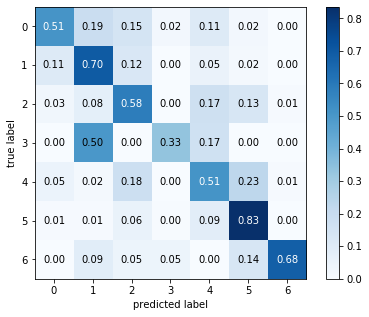


              precision    recall  f1-score   support

       akiec       0.55      0.51      0.53        47
         bcc       0.57      0.70      0.63        56
         bkl       0.46      0.58      0.51       106
          df       0.29      0.33      0.31         6
         mel       0.42      0.51      0.46       117
          nv       0.92      0.83      0.88       648
        vasc       0.83      0.68      0.75        22

    accuracy                           0.74      1002
   macro avg       0.58      0.59      0.58      1002
weighted avg       0.77      0.74      0.75      1002



In [29]:
clf_metrics(y_t, predictions_xception_linear, class_names, title = 'Xception+SVM(kernel Linear)')

In [45]:
dump(xception_svm_linear, 'models/xception_svm_linear.joblib') 

['models/xception_svm_linear.joblib']

### Kernel Linear com Normalização

In [30]:
xception_svm_linear_norm = train_svm_classifier(train_features_xception, y_train, kernel = 'linear', normal = True, C=1)

In [31]:
predictions_xception_linear_norm = xception_svm_linear_norm.predict(np.array(list(map(normalizar,test_features_xception))))

Matriz de Confusão:


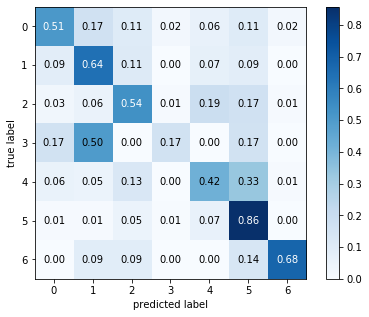


              precision    recall  f1-score   support

       akiec       0.52      0.51      0.52        47
         bcc       0.55      0.64      0.59        56
         bkl       0.48      0.54      0.51       106
          df       0.14      0.17      0.15         6
         mel       0.41      0.42      0.42       117
          nv       0.89      0.86      0.87       648
        vasc       0.79      0.68      0.73        22

    accuracy                           0.74      1002
   macro avg       0.54      0.55      0.54      1002
weighted avg       0.75      0.74      0.74      1002



In [32]:
clf_metrics(y_t, predictions_xception_linear_norm, class_names, title = 'Xception+normalizacao+SVM(kernel Linear)')

In [46]:
dump(xception_svm_linear_norm, 'models/xception_svm_linear_norm.joblib') 

['models/xception_svm_linear_norm.joblib']

## SVM + Vgg16

### Kernel RBF

In [42]:
vgg16_svm = train_svm_classifier(train_features_vgg16, y_train)

In [43]:
predictions_vgg16 = vgg16_svm.predict(test_features_vgg16)

Matriz de Confusão:


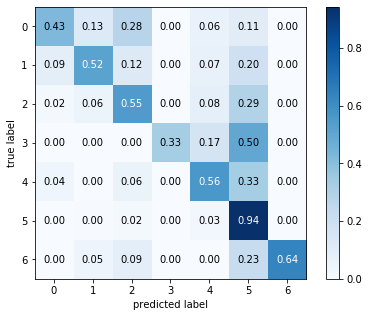


              precision    recall  f1-score   support

       akiec       0.59      0.43      0.49        47
         bcc       0.64      0.52      0.57        56
         bkl       0.58      0.55      0.56       106
          df       1.00      0.33      0.50         6
         mel       0.65      0.56      0.60       117
          nv       0.87      0.94      0.90       648
        vasc       1.00      0.64      0.78        22

    accuracy                           0.80      1002
   macro avg       0.76      0.57      0.63      1002
weighted avg       0.79      0.80      0.79      1002



In [44]:
clf_metrics(y_t, predictions_vgg16, class_names, title = 'VGG16+SVM(kernel Rbf)')

In [47]:
dump(vgg16_svm, 'models/vgg16_svm_rbf.joblib') 

['models/vgg16_svm.joblib']

### Kernel RBF com normalização

In [16]:
vgg16_svm_norm = train_svm_classifier(train_features_vgg16, y_train, normal=True)

In [18]:
predictions_vgg16_norm = vgg16_svm_norm.predict(np.array(list(map(normalizar,test_features_vgg16))))

Matriz de Confusão:


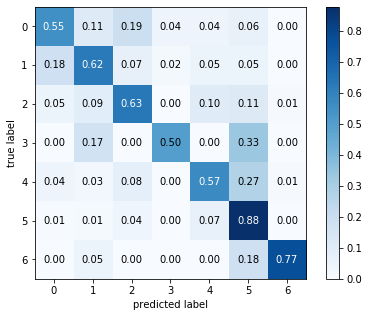


              precision    recall  f1-score   support

       akiec       0.52      0.55      0.54        47
         bcc       0.56      0.62      0.59        56
         bkl       0.60      0.63      0.61       106
          df       0.43      0.50      0.46         6
         mel       0.53      0.57      0.55       117
          nv       0.91      0.88      0.89       648
        vasc       0.89      0.77      0.83        22

    accuracy                           0.78      1002
   macro avg       0.63      0.65      0.64      1002
weighted avg       0.79      0.78      0.79      1002



In [20]:
clf_metrics(y_t, predictions_vgg16_norm, class_names, title = 'VGG16+normalizacao+SVM(kernel Rbf)')

In [21]:
dump(vgg16_svm_norm, 'models/vgg16_svm_rbf_norm.joblib') 

['models/vgg16_svm_rbf_norm.joblib']

### Kernel Linear 

In [22]:
vgg16_svm_linear = train_svm_classifier(train_features_vgg16, y_train, kernel = "linear", C=1)

In [23]:
predictions_vgg16_linear = vgg16_svm_linear.predict(test_features_vgg16)

Matriz de Confusão:


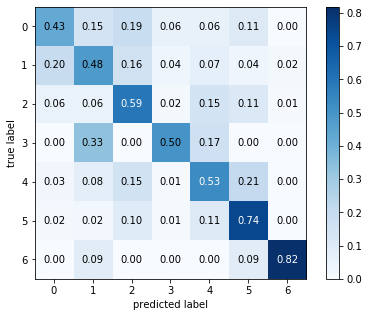


              precision    recall  f1-score   support

       akiec       0.39      0.43      0.41        47
         bcc       0.40      0.48      0.44        56
         bkl       0.39      0.59      0.47       106
          df       0.17      0.50      0.25         6
         mel       0.40      0.53      0.46       117
          nv       0.91      0.74      0.82       648
        vasc       0.82      0.82      0.82        22

    accuracy                           0.67      1002
   macro avg       0.50      0.58      0.52      1002
weighted avg       0.74      0.67      0.70      1002



In [24]:
clf_metrics(y_t, predictions_vgg16_linear, class_names, title = 'VGG16+SVM(kernel Linear)')

In [30]:
dump(vgg16_svm_linear, 'models/vgg16_svm_linear.joblib') 

['models/vgg16_svm_linear.joblib']

### Kernel Linear com Normalização

In [25]:
vgg16_svm_linear_norm = train_svm_classifier(train_features_vgg16, y_train, normal=True, kernel = "linear", C=1)

In [28]:
predictions_vgg16_linear_norm = vgg16_svm_linear_norm.predict(np.array(list(map(normalizar,test_features_vgg16))))

Matriz de Confusão:


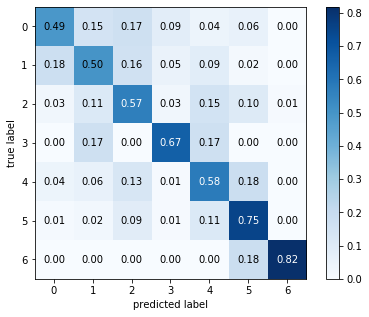


              precision    recall  f1-score   support

       akiec       0.47      0.49      0.48        47
         bcc       0.40      0.50      0.44        56
         bkl       0.40      0.57      0.47       106
          df       0.20      0.67      0.31         6
         mel       0.41      0.58      0.48       117
          nv       0.92      0.75      0.83       648
        vasc       0.90      0.82      0.86        22

    accuracy                           0.69      1002
   macro avg       0.53      0.62      0.55      1002
weighted avg       0.75      0.69      0.71      1002



In [29]:
clf_metrics(y_t, predictions_vgg16_linear_norm, class_names,  title = 'VGG16+normalizacao+SVM(kernel Linear)')

In [31]:
dump(vgg16_svm_linear_norm, 'models/vgg16_svm_linear_norm.joblib') 

['models/vgg16_svm_linear_norm.joblib']

## SVM + Resnet50

### Kernel RBF

In [32]:
resnet50_svm = train_svm_classifier(train_features_resnet50, y_train)

In [33]:
predictions_resnet50 = resnet50_svm.predict(test_features_resnet50)

Matriz de Confusão:


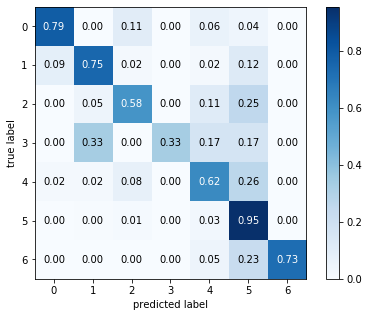


              precision    recall  f1-score   support

       akiec       0.82      0.79      0.80        47
         bcc       0.78      0.75      0.76        56
         bkl       0.73      0.58      0.65       106
          df       1.00      0.33      0.50         6
         mel       0.68      0.62      0.65       117
          nv       0.89      0.95      0.92       648
        vasc       0.94      0.73      0.82        22

    accuracy                           0.85      1002
   macro avg       0.83      0.68      0.73      1002
weighted avg       0.84      0.85      0.84      1002



In [34]:
clf_metrics(y_t, predictions_resnet50, class_names, title = 'Resnet50+SVM(kernel Rbf)')

In [35]:
dump(resnet50_svm, 'models/resnet50_svm_rbf.joblib') 

['models/resnet50_svm_rbf.joblib']

### Kernel RBF com normalização

In [22]:
resnet50_svm_norm = train_svm_classifier(train_features_resnet50, y_train, normal = True)

In [23]:
predictions_resnet50_norm = resnet50_svm_norm.predict(np.array(list(map(normalizar,test_features_resnet50))))

Matriz de Confusão:


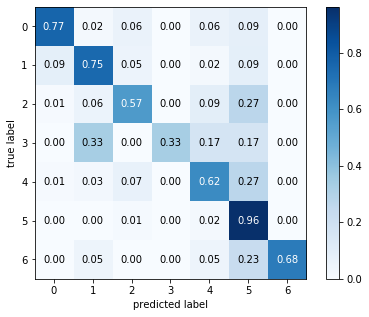


              precision    recall  f1-score   support

       akiec       0.82      0.77      0.79        47
         bcc       0.74      0.75      0.74        56
         bkl       0.72      0.57      0.63       106
          df       0.67      0.33      0.44         6
         mel       0.73      0.62      0.67       117
          nv       0.89      0.96      0.93       648
        vasc       0.94      0.68      0.79        22

    accuracy                           0.85      1002
   macro avg       0.79      0.67      0.71      1002
weighted avg       0.84      0.85      0.84      1002



In [24]:
clf_metrics(y_t, predictions_resnet50_norm, class_names, title = 'Resnet50+normalizacao+SVM(kernel Rbf)')

In [25]:
dump(resnet50_svm_norm, 'models/resnet50_svm_rbf_norm.joblib') 

['models/resnet50_svm_rbf_norm.joblib']

### Kernel Linear

In [26]:
resnet50_svm_linear = train_svm_classifier(train_features_resnet50, y_train, kernel = "linear", C=1)

In [27]:
predictions_resnet50_linear = resnet50_svm_linear.predict(test_features_resnet50)

Matriz de Confusão:


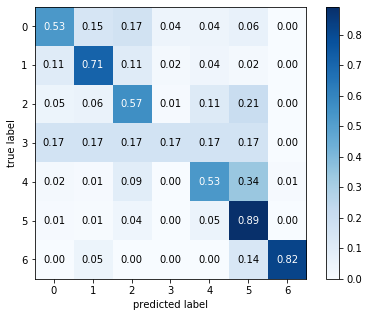


              precision    recall  f1-score   support

       akiec       0.56      0.53      0.54        47
         bcc       0.67      0.71      0.69        56
         bkl       0.54      0.57      0.55       106
          df       0.20      0.17      0.18         6
         mel       0.54      0.53      0.54       117
          nv       0.89      0.89      0.89       648
        vasc       0.90      0.82      0.86        22

    accuracy                           0.78      1002
   macro avg       0.61      0.60      0.61      1002
weighted avg       0.78      0.78      0.78      1002



In [28]:
clf_metrics(y_t, predictions_resnet50_linear, class_names, title = 'Resnet50+SVM(kernel Linear)')

In [32]:
dump(resnet50_svm_linear, 'models/resnet50_svm_linear.joblib') 

['models/resnet50_svm_linear.joblib']

### Kernel Linear com normalização

In [29]:
resnet50_svm_linear_norm = train_svm_classifier(train_features_resnet50, y_train, normal = True, kernel = "linear", C=1)

In [30]:
predictions_resnet50_linear_norm = resnet50_svm_linear_norm.predict(np.array(list(map(normalizar,test_features_resnet50))))

Matriz de Confusão:


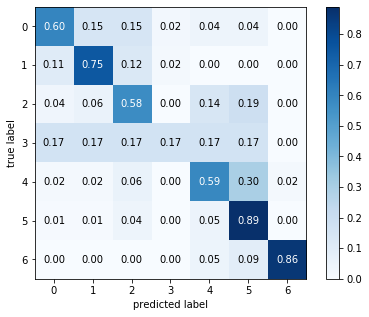


              precision    recall  f1-score   support

       akiec       0.60      0.60      0.60        47
         bcc       0.67      0.75      0.71        56
         bkl       0.55      0.58      0.56       106
          df       0.33      0.17      0.22         6
         mel       0.57      0.59      0.58       117
          nv       0.91      0.89      0.90       648
        vasc       0.90      0.86      0.88        22

    accuracy                           0.79      1002
   macro avg       0.65      0.63      0.64      1002
weighted avg       0.80      0.79      0.80      1002



In [31]:
clf_metrics(y_t, predictions_resnet50_linear_norm, class_names, title = 'Resnet50+normalizacao+SVM(kernel Linear)')

In [33]:
dump(resnet50_svm_linear_norm, 'models/resnet50_svm_linear_norm.joblib') 

['models/resnet50_svm_linear_norm.joblib']

## SVM + InceptionV3

### Kernel RBF

In [34]:
inceptionv3_svm = train_svm_classifier(train_features_inceptionv3, y_train)

In [35]:
predictions_inceptionv3 = inceptionv3_svm.predict(test_features_inceptionv3)

Matriz de Confusão:


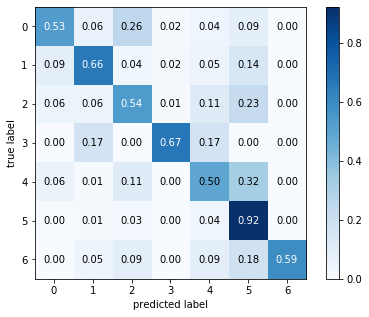


              precision    recall  f1-score   support

       akiec       0.54      0.53      0.54        47
         bcc       0.69      0.66      0.67        56
         bkl       0.55      0.54      0.54       106
          df       0.50      0.67      0.57         6
         mel       0.57      0.50      0.53       117
          nv       0.88      0.92      0.90       648
        vasc       1.00      0.59      0.74        22

    accuracy                           0.79      1002
   macro avg       0.68      0.63      0.64      1002
weighted avg       0.79      0.79      0.79      1002



In [36]:
clf_metrics(y_t, predictions_inceptionv3, class_names, title = 'Inceptionv3+SVM(kernel Rbf)')

In [37]:
dump(inceptionv3_svm, 'models/inceptionv3_svm_rbf.joblib') 

['models/inceptionv3_svm_rbf.joblib']

### Kernel RBF com normalização

In [53]:
inceptionv3_svm_norm = train_svm_classifier(train_features_inceptionv3, y_train, normal = True, gamma = 0.0001)

In [54]:
predictions_inceptionv3_norm = inceptionv3_svm_norm.predict(np.array(list(map(normalizar,test_features_inceptionv3))))

Matriz de Confusão:


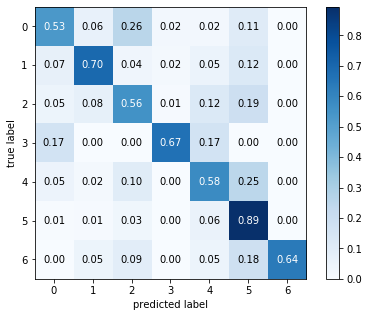


              precision    recall  f1-score   support

       akiec       0.56      0.53      0.54        47
         bcc       0.66      0.70      0.68        56
         bkl       0.54      0.56      0.55       106
          df       0.57      0.67      0.62         6
         mel       0.55      0.58      0.56       117
          nv       0.90      0.89      0.90       648
        vasc       1.00      0.64      0.78        22

    accuracy                           0.79      1002
   macro avg       0.68      0.65      0.66      1002
weighted avg       0.79      0.79      0.79      1002



In [55]:
clf_metrics(y_t, predictions_inceptionv3_norm, class_names, title = 'Inceptionv3+normalizacao+SVM(kernel Rbf)')

In [56]:
dump(inceptionv3_svm_norm, 'models/inceptionv3_svm_rbf_norm.joblib') 

['models/inceptionv3_svm_rbf_norm.joblib']

### Kernel Linear

In [30]:
inceptionv3_svm_linear = train_svm_classifier(train_features_inceptionv3, y_train, kernel = 'linear', C=1)

In [31]:
predictions_inceptionv3_linear = inceptionv3_svm_linear.predict(test_features_inceptionv3)

Matriz de Confusão:


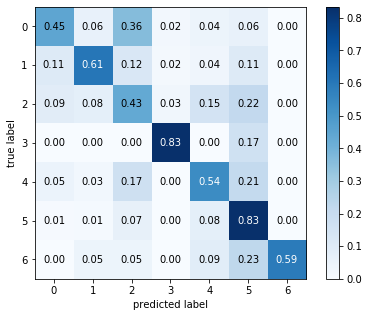


              precision    recall  f1-score   support

       akiec       0.43      0.45      0.44        47
         bcc       0.61      0.61      0.61        56
         bkl       0.34      0.43      0.38       106
          df       0.45      0.83      0.59         6
         mel       0.47      0.54      0.50       117
          nv       0.90      0.83      0.86       648
        vasc       1.00      0.59      0.74        22

    accuracy                           0.72      1002
   macro avg       0.60      0.61      0.59      1002
weighted avg       0.75      0.72      0.73      1002



In [32]:
clf_metrics(y_t, predictions_inceptionv3_linear, class_names, title = 'Inceptionv3+SVM(kernel Linear)')

In [33]:
dump(inceptionv3_svm_linear, 'models/inceptionv3_svm_linear.joblib') 

['models/inceptionv3_svm_linear.joblib']

### Kernel Linear com normalização

In [17]:
inceptionv3_svm_linear_norm = train_svm_classifier(train_features_inceptionv3, y_train, kernel = 'linear', normal = True, C=1)

In [18]:
predictions_inceptionv3_linear_norm = inceptionv3_svm_linear_norm.predict(np.array(list(map(normalizar,test_features_inceptionv3))))

Matriz de Confusão:


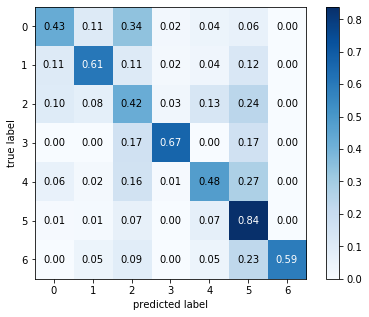


              precision    recall  f1-score   support

       akiec       0.41      0.43      0.42        47
         bcc       0.60      0.61      0.60        56
         bkl       0.34      0.42      0.38       106
          df       0.33      0.67      0.44         6
         mel       0.46      0.48      0.47       117
          nv       0.88      0.84      0.86       648
        vasc       1.00      0.59      0.74        22

    accuracy                           0.71      1002
   macro avg       0.57      0.58      0.56      1002
weighted avg       0.74      0.71      0.72      1002



In [20]:
clf_metrics(y_t, predictions_inceptionv3_linear_norm, class_names, title = 'Inceptionv3+normalizacao+SVM(kernel Linear)')

In [34]:
dump(inceptionv3_svm_linear_norm, 'models/inceptionv3_svm_linear_norm.joblib') 

['models/inceptionv3_svm_linear_norm.joblib']

## Area under roc curve

In [13]:
def plot_clf_roc_curve(clf,x_test,y_test, title):
    y_pred = clf.predict_proba(x_test)
    clf_roc_curve(y_test, y_pred, title)

Roc Curve:


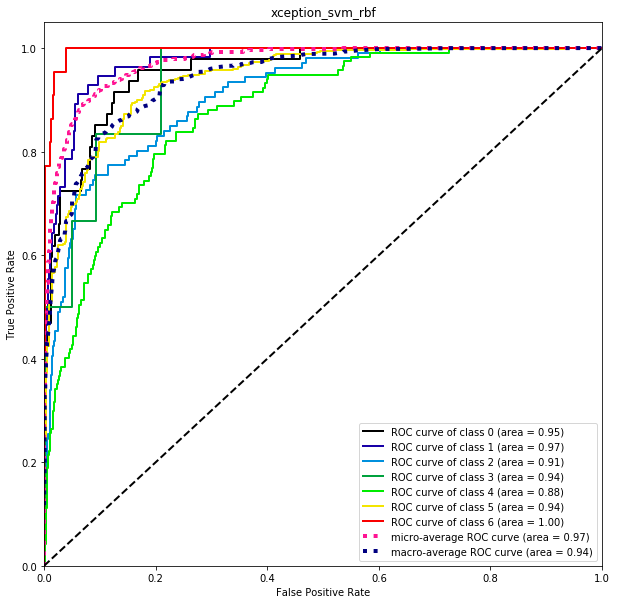


Roc Curve:


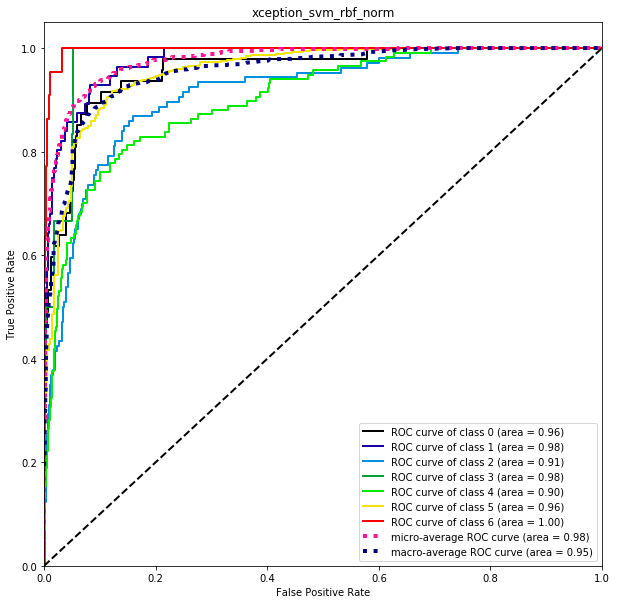


Roc Curve:


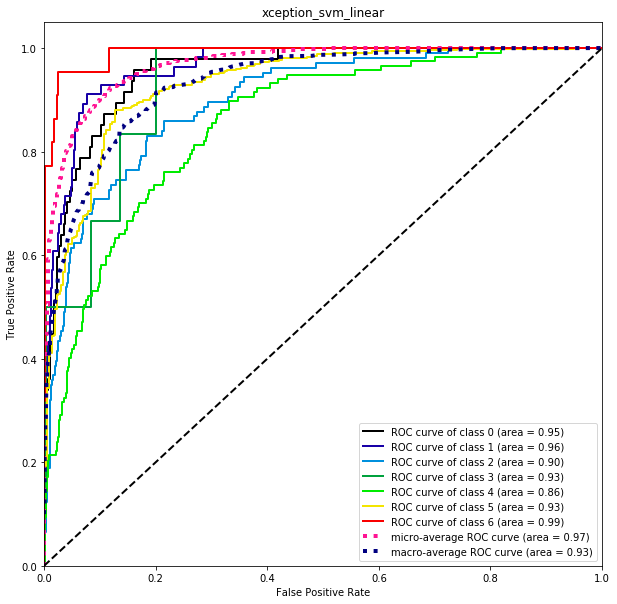


Roc Curve:


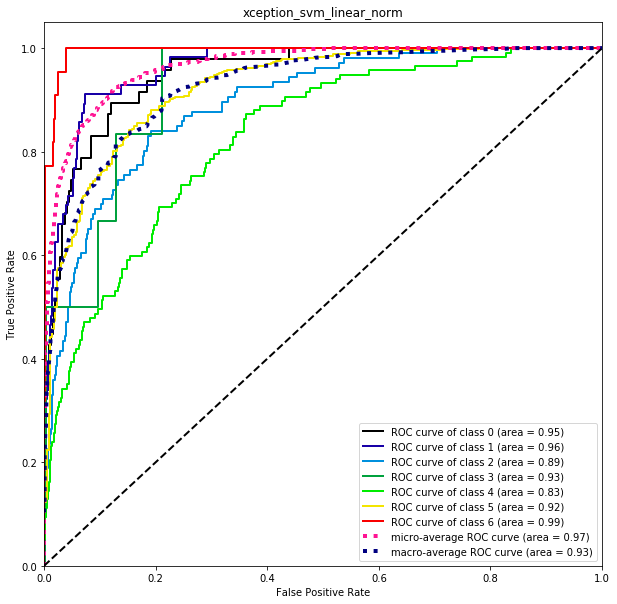


Roc Curve:


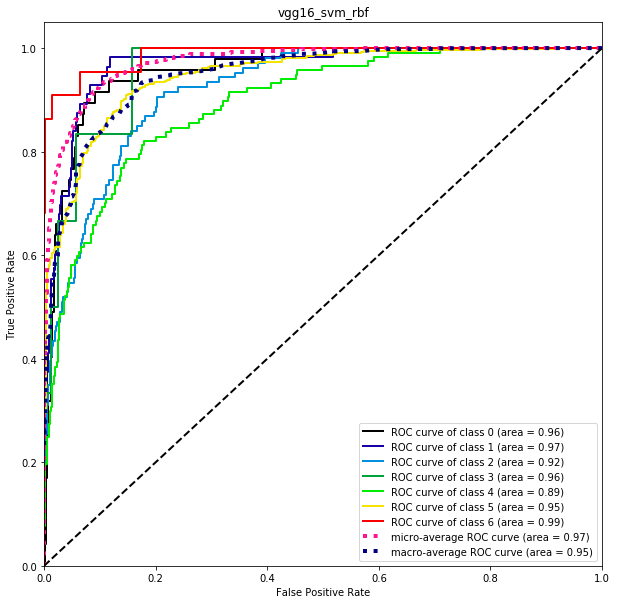


Roc Curve:


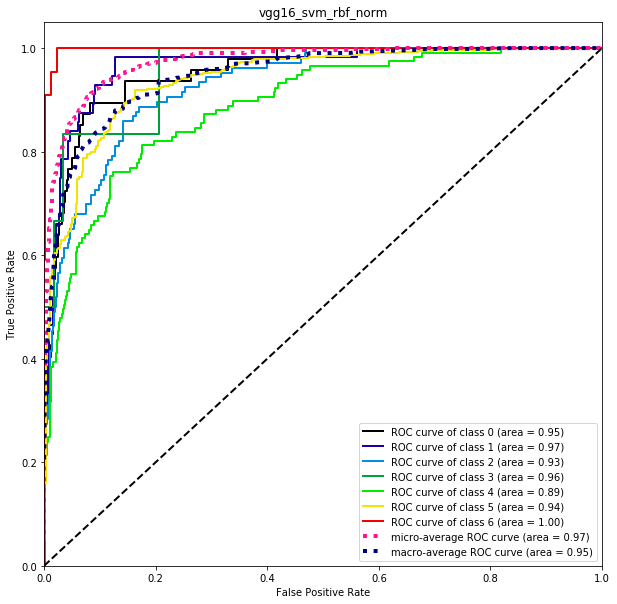


Roc Curve:


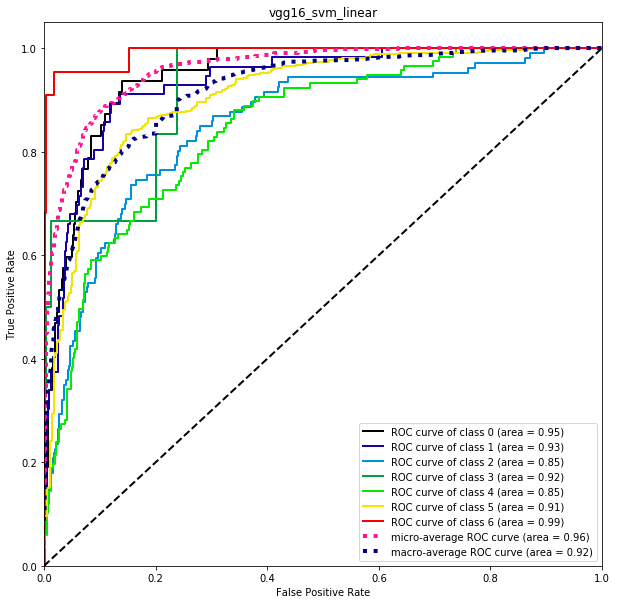


Roc Curve:


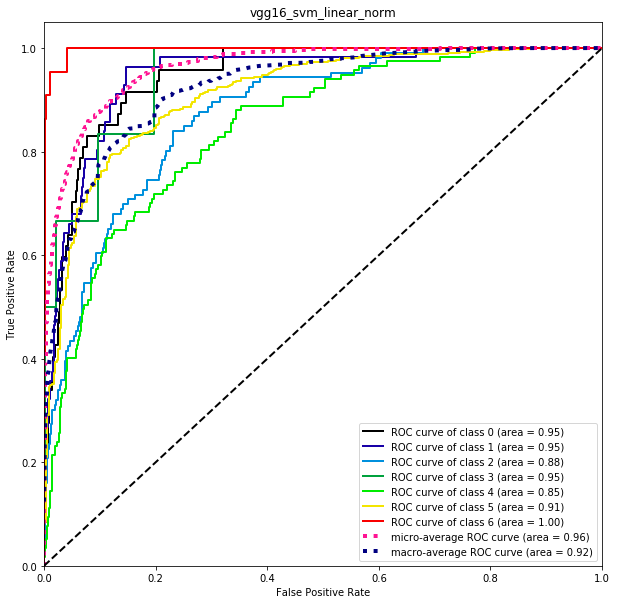


Roc Curve:


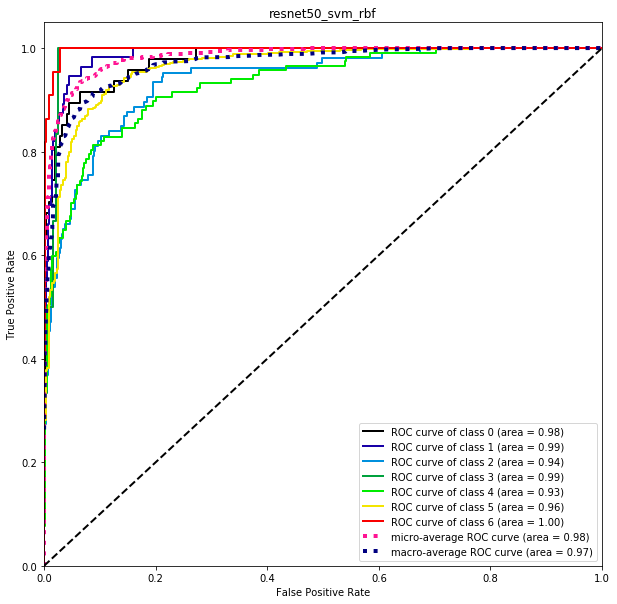


Roc Curve:


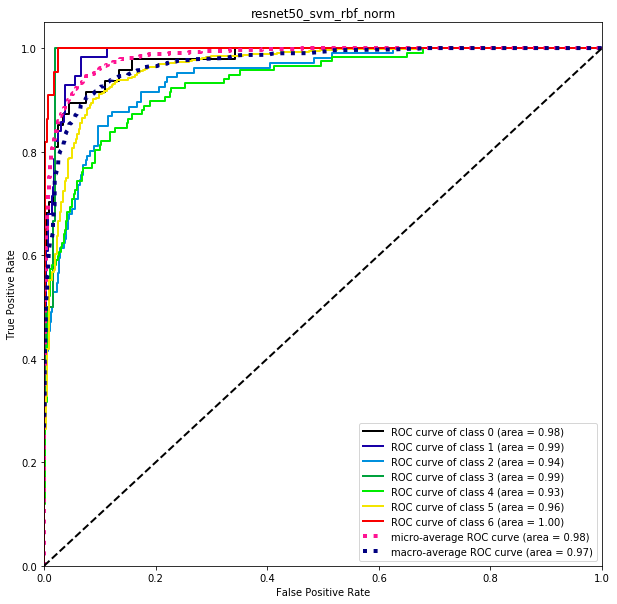


Roc Curve:


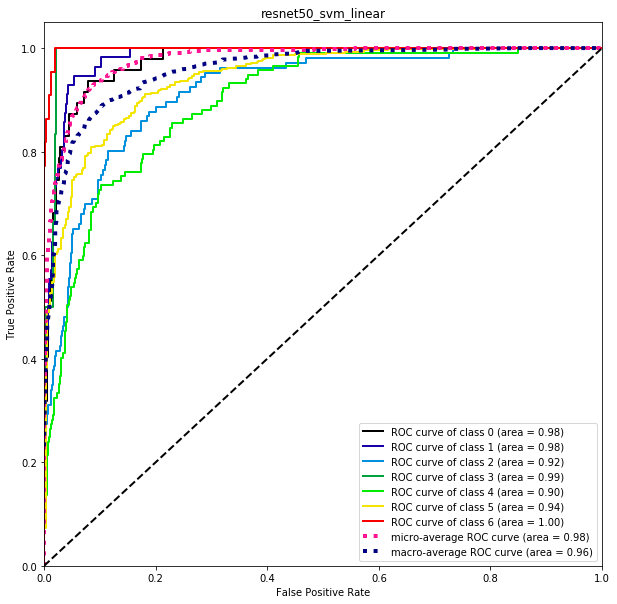


Roc Curve:


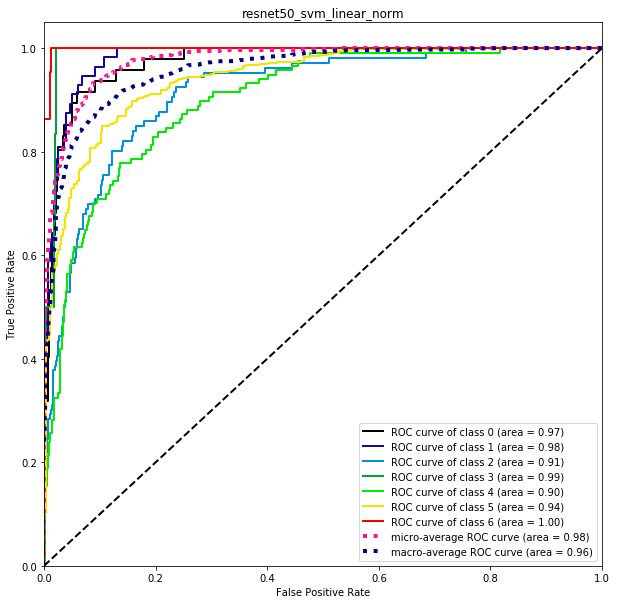


Roc Curve:


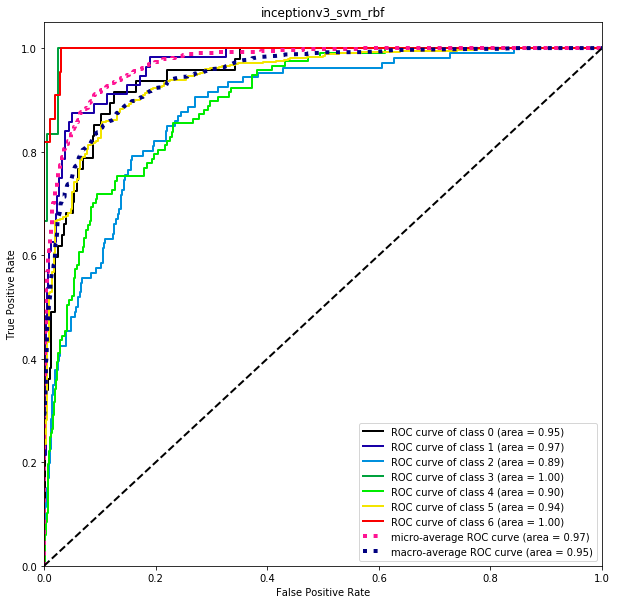


Roc Curve:


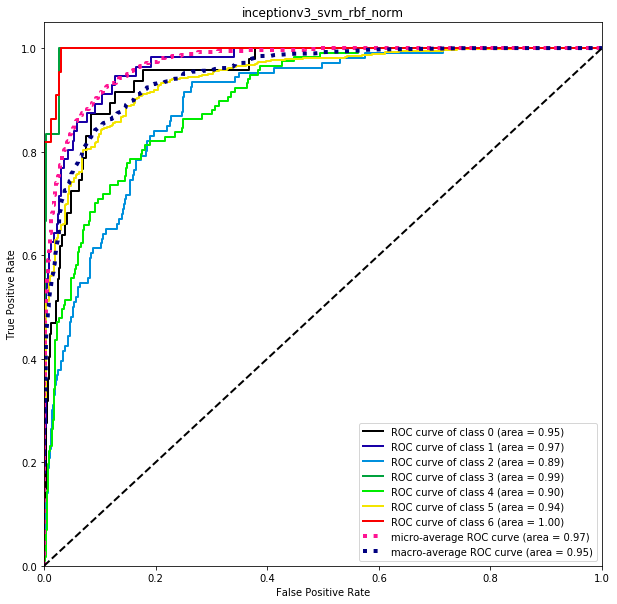


Roc Curve:


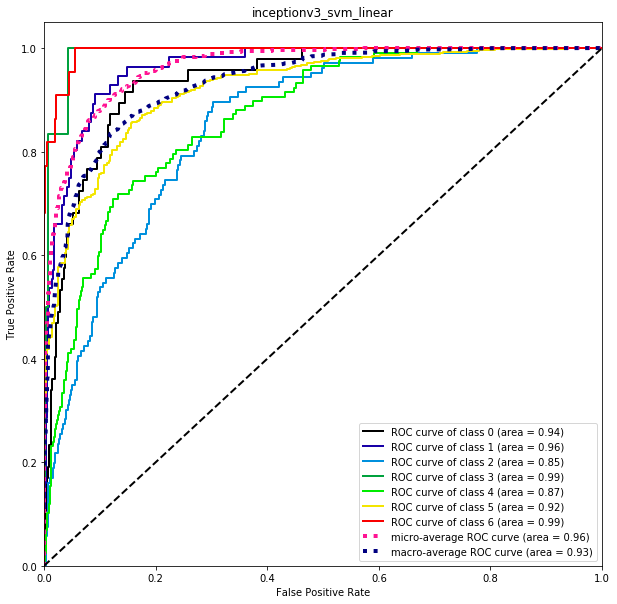


Roc Curve:


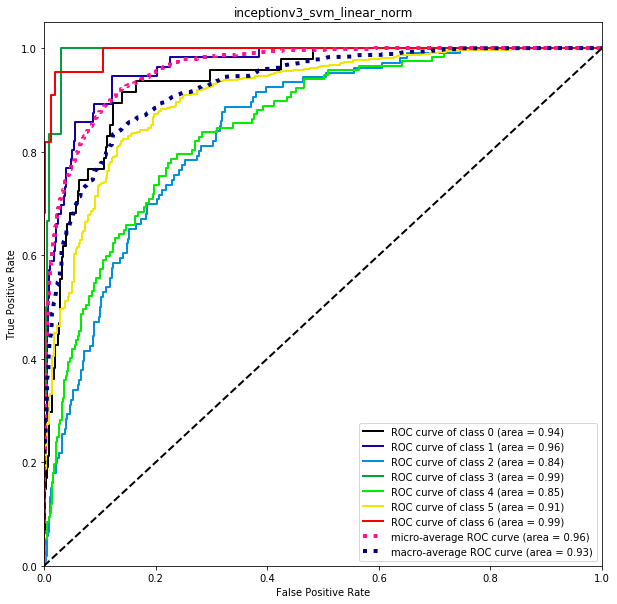

In [16]:
test_features_xception_norm = np.array(list(map(normalizar,test_features_xception)))

plot_clf_roc_curve(load('models/xception_svm_rbf.joblib'), test_features_xception, y_t, "xception_svm_rbf")
plot_clf_roc_curve(load('models/xception_svm_rbf_norm.joblib'), test_features_xception_norm, y_t, "xception_svm_rbf_norm")
plot_clf_roc_curve(load('models/xception_svm_linear.joblib'), test_features_xception, y_t, "xception_svm_linear")
plot_clf_roc_curve(load('models/xception_svm_linear_norm.joblib'), test_features_xception_norm, y_t, "xception_svm_linear_norm")

test_features_vgg16_norm = np.array(list(map(normalizar,test_features_vgg16)))

plot_clf_roc_curve(load('models/vgg16_svm_rbf.joblib'), test_features_vgg16, y_t, "vgg16_svm_rbf")
plot_clf_roc_curve(load('models/vgg16_svm_rbf_norm.joblib'), test_features_vgg16_norm, y_t, "vgg16_svm_rbf_norm")
plot_clf_roc_curve(load('models/vgg16_svm_linear.joblib'), test_features_vgg16, y_t, "vgg16_svm_linear")
plot_clf_roc_curve(load('models/vgg16_svm_linear_norm.joblib'), test_features_vgg16_norm, y_t, "vgg16_svm_linear_norm")

test_features_resnet50_norm = np.array(list(map(normalizar,test_features_resnet50)))

plot_clf_roc_curve(load('models/resnet50_svm_rbf.joblib'), test_features_resnet50, y_t, "resnet50_svm_rbf")
plot_clf_roc_curve(load('models/resnet50_svm_rbf_norm.joblib'), test_features_resnet50_norm, y_t, "resnet50_svm_rbf_norm")
plot_clf_roc_curve(load('models/resnet50_svm_linear.joblib'), test_features_resnet50, y_t, "resnet50_svm_linear")
plot_clf_roc_curve(load('models/resnet50_svm_linear_norm.joblib'), test_features_resnet50_norm, y_t, "resnet50_svm_linear_norm")

test_features_inceptionv3_norm = np.array(list(map(normalizar,test_features_inceptionv3)))

plot_clf_roc_curve(load('models/inceptionv3_svm_rbf.joblib'), test_features_inceptionv3, y_t, "inceptionv3_svm_rbf")
plot_clf_roc_curve(load('models/inceptionv3_svm_rbf_norm.joblib'), test_features_inceptionv3_norm, y_t, "inceptionv3_svm_rbf_norm")
plot_clf_roc_curve(load('models/inceptionv3_svm_linear.joblib'), test_features_inceptionv3, y_t, "inceptionv3_svm_linear")
plot_clf_roc_curve(load('models/inceptionv3_svm_linear_norm.joblib'), test_features_inceptionv3_norm, y_t, "inceptionv3_svm_linear_norm")

